# Machine Learning 0 - Introduction

In this lab, we will introduce the classification problem that we will be working on for the last three labs. The objectives of the lab are:

* Examine the dataset and prepare the basic pipeline that will be used in the next lab.
* Make sure that we use a correct methodology for comparing the algorithms
* Get used to working with the [scikit-learn](https://scikit-learn.org/stable/) library.

## Important note

For the machine learning labs, **each student must write a report** (one report for all labs together) which will be used during the oral exam. This report should highlight the different methods used during the labs, but also how you validated each method and compared their results.

## Introduction to the dataset

The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset has been collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It consists of 60.000 32x32 colour images, split in 10 classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'.

*Reference: Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.* PDF available at https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

For the purpose of the INFO-H-501 laboratories, we will use a subset of those images by only taking 3 different classes: 'airplane', 'bird' and 'horse'.

[Click here to download](https://my.pcloud.com/publink/show?code=XZJUCPkZqiVxqtn8CXRB7D78YKt88RJvzWyk) the modified dataset. Extract the ZIP file and put the CIFAR10 folder in the same directory as the notebook.

The images are 32x32 8-bit **RGB**, and from these we extracted **Histogram of Gradient** vectors (16 orientations x 16 blocks = 256 values in HoG vector).

The following code pre-loads all of this data (make sure that you have the [lab_tools.py](https://github.com/odebeir/info-h-500-501/blob/master/LABS1/lab_tools.py) file in the same directory as the notebook, if you didn't clone the repository):

In [1]:
from lab_tools import CIFAR10, get_hog_image

Pre-loading training data
Pre-loading test data


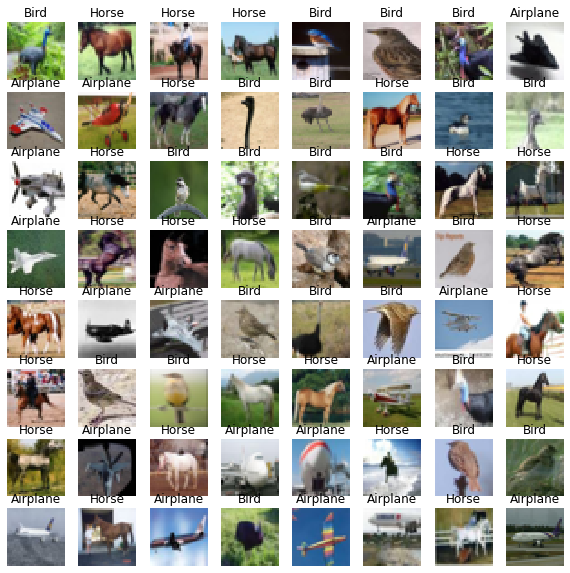

In [2]:
dataset = CIFAR10('./CIFAR10/')
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(dataset.train['images'][i].reshape((32,32,3)), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]])
    plt.axis('off')
plt.show()

We can also have a look at some HoG images:

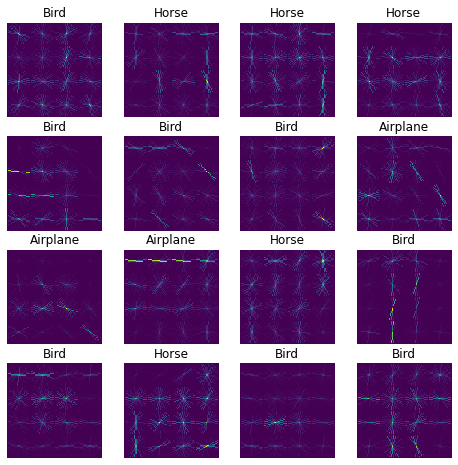

In [3]:
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    hog = dataset.train['hog'][i].reshape((4,4,16))
    plt.imshow(get_hog_image(hog, 128), interpolation='none')
    plt.title(dataset.labels[dataset.train['labels'][i]])
    plt.axis('off')
plt.show()

Note that this is an "image" representation of the HoG, but that the actual data that we will be working on is a size 256 vector for each image. Our **feature space** has therefore 256 dimensions. 

## Exploring the dataset

The *dataset* object gives you access to different attributes:

* *dataset.path* contains the path to the CIFAR10 folder.
* *dataset.labels* contains the name of the three classes
* *dataset.train* and *dataset.test* are dictionaries containing three numpy arrays each:
    * *images* contains the RGB images
    * *hog* contains the HoG vectors
    * *labels* contains the label for each image

In [4]:
print(dataset.path)
print(dataset.labels)
print(dataset.train.keys())
print(dataset.train['hog'].shape)

./CIFAR10/
['Airplane', 'Bird', 'Horse']
dict_keys(['images', 'hog', 'labels'])
(15000, 256)


### Quick questions:

The dataset has already been split into a training set (dataset.train) and a test set (dataset.test).

* How many images are in the training set ?
* How many images are in the test set ?
* What is the class distribution of the dataset ?

In [16]:
print("Dans le trainset, il y a :")
print(dataset.train['images'].shape)
print("Dans le test set, il y a :")
print(dataset.test['images'].shape)
print("La distribution des classes dans le train set est la suivante")
for c in range (0,3):
    print(dataset.labels[c],(dataset.train["labels"]==c).sum())

Dans le trainset, il y a :
(15000, 3072)
Dans le test set, il y a :
(3000, 3072)
La distribution des classes dans le train set est la suivante
Airplane 5000
Bird 5000
Horse 5000


### Descriptive data analysis

Look at the HoG data from the training set. What are the characteristics of the dataset ? Do you think that some pre-processing may be required to help with the different algorithms ?

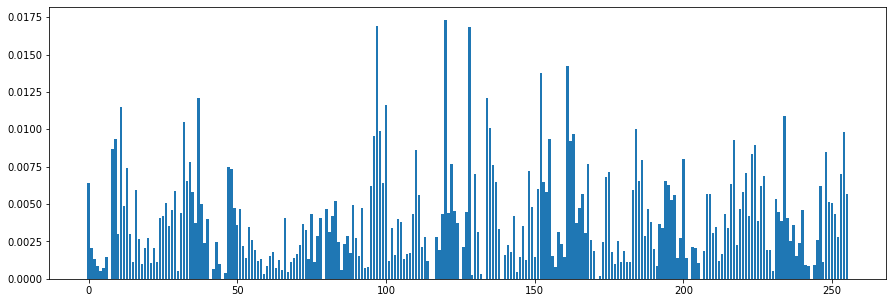

In [17]:
plt.figure(figsize=(15,5))
plt.bar(range(256),dataset.train['hog'][0])
plt.show()

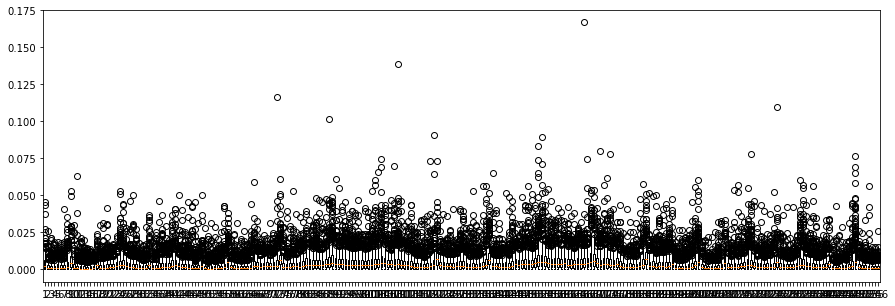

In [18]:
plt.figure(figsize=(15,5))
plt.boxplot(dataset.train['hog'][::50])
plt.show()

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [73]:
X = dataset.train['hog']
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)
pca = PCA(n_components = 0.95) #Variance of 95%
pca.fit(X_rescaled)
X_pca = pca.transform(X_rescaled)
print(X.shape)
print(X_pca.shape)

(15000, 256)
(15000, 203)


In [75]:
X = dataset.test['hog']
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)
# Il ne faut pas refit
X_test_pca = pca.transform(X_rescaled)
print(X.shape)
print(X_test_pca.shape)

(3000, 256)
(3000, 203)


## Introduction to scikit-learn

[Scikit-learn](https://scikit-learn.org/stable/) is a very well documented machine learning library in Python. It contains many algorithms for [classification](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning), and makes the whole process of building a machine learning pipeline relatively straightforward. There are many examples in the documentation, as well as relatively complete theoretical explanations, so I really encourage you to take the time to read it if some things are not clear.

Let's make a very simple example. We are going to use the [Ridge Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), which is a very basic linear model.

In [19]:
from sklearn.linear_model import RidgeClassifier

To use a classifier with scikit-image, we generally have three steps:

* Create an instance of the class of the classifier (here: RidgeClassifier). The constructor will generally contain many arguments that can be modified, and that are explained in the documentation. There will also generally be default values for all of them, so in this simple example we will just use those:

In [25]:
clf = RidgeClassifier()

* Use the *fit* method with, as arguments, the training data (in our case, the HoG vectors) and the corresponding labels. This will start the main training algorithm, trying to fit the parameters of the classifier with the training data:

In [26]:
clf.fit(dataset.train['hog'], dataset.train['labels'])

RidgeClassifier()

* Use the *predict* method to get the prediction of the classifier on the data given as argument. In this case, we get the predictions on the data that was just used for training. **What kind of performance will that give us?**

In [27]:
pred = clf.predict(dataset.train['hog'])
print(pred.shape)

(15000,)


We can then evaluate those predictions. Scikit-learn provides many different [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) for evaluating the performances of a classifier. The most simple of those is the accuracy, which is simply the number of correct predictions divided by the total number of predictions:

In [28]:
from sklearn.metrics import accuracy_score

score = accuracy_score(dataset.train['labels'], pred)
print(score)

# Not that it's fairly easy to compute that score "by hand":
T = (pred==dataset.train['labels']).sum()
print(T, len(pred), T/len(pred))

0.7356666666666667
11035 15000 0.7356666666666667


In a multiclass problem, it's often also very useful to look at the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix), which gives us more information on which classes are often mistaken for each other:

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(dataset.train['labels'], pred)
print(cm)

[[3812  740  448]
 [ 742 3236 1022]
 [ 337  676 3987]]


Note that the rows represent the **true labels** and the columns the **predicted labels**. So this mean that, in this case, out of the 5000 images of class 0 ("Airplane"), 3812 were correctly classified, 740 were classified as "Bird" and 448 as "Horse").

### Quick question

* Modify the code to estimate the **predictive** performance of the algorithm (without using the test set).

In [30]:
clf = RidgeClassifier()
# Comme les data sont bien mélangées, on peut simplement couper le train set en deux parties :
train_data = dataset.train['hog'][:13500]
train_labels = dataset.train['labels'][:13500]
clf.fit(train_data, train_labels)

RidgeClassifier()

In [33]:
test_data = dataset.train['hog'][13500:]
pred = clf.predict(test_data)
print(pred.shape)

(1500,)


In [34]:
test_labels = dataset.train['labels'][13500:]
score = accuracy_score(test_labels, pred)
print(score)

0.7346666666666667


### Résultats avec PCA

Juste pour voir l'impact de la réduction des features sur l'accuracy.

In [42]:
clf_pca = RidgeClassifier()
train_data = X_pca
train_labels = dataset.train['labels']
clf_pca.fit(train_data, train_labels)

RidgeClassifier()

In [43]:
test_data = X_pca
pred = clf_pca.predict(test_data)
print(pred.shape)

(15000,)


In [44]:
test_labels = dataset.train['labels']
score = accuracy_score(test_labels, pred)
print(score)
cm = confusion_matrix(dataset.train['labels'], pred)
print(cm)

0.7555333333333333
[[3854  694  452]
 [ 647 3465  888]
 [ 260  726 4014]]


In [45]:
clf = RidgeClassifier()
# Comme les data sont bien mélangées, on peut simplement couper le train set en deux parties :
train_data = X_pca[:13500]
train_labels = dataset.train['labels'][:13500]
clf.fit(train_data, train_labels)

RidgeClassifier()

In [46]:
test_data = X_pca[13500:]
pred = clf.predict(test_data)
print(pred.shape)

(1500,)


In [47]:
test_labels = dataset.train['labels'][13500:]
score = accuracy_score(test_labels, pred)
print(score)

0.7453333333333333


Meilleurs résultats avec les data qui ont été preprocessed.

## How can we find the "best" algorithm?

What we have shown above served to illustrate how scikit-learn classifiers work, but we now have to build a valid machine learning pipeline to compare the different algorithms that we will use in the next labs.

As we have said earlier, we have already split the dataset into a "training" and a "test" set. It is clear that the final evaluation should take place on the test set.

But in addition to comparing the algorithms between each other, we also have to find the best "hyper-parameters" for each algorithm. For example, in our RidgeClassifier example, there is a regularization parameters, *alpha*, which by default was set to 1.0. Can we improve the performance of the algorithm by modifying this parameter ?

### Side-note: parameter vs hyper-parameter

In general, when talking about machine learning models, **parameters** are what the algorithm learns with the data (if we are for instance learning a linear regression y = ax+b, the "parameters" would be a and b), while **hyper-parameters** are modifiers to the model or to the pipeline (for instance, if we are generalizing to a polynomial regression, the degree of the polynome would be an hyper-parameter).

### Cross-validation

The most common way of finding the best hyper-parameters of a classifier is to use [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

* Using the [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) method from scikit-learn, find the best *alpha* hyper-parameter for the RidgeClassifier: 

In [41]:
from sklearn.model_selection import cross_val_score

In [51]:
scores = cross_val_score(clf,dataset.train['hog'],dataset.train['labels'])
print(scores)

[0.725      0.73333333 0.724      0.72166667 0.72633333]


In [58]:
alpha = [0.02, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4]
for a in alpha:
    clf = RidgeClassifier(alpha=a)
    scores = cross_val_score(clf,dataset.train['hog'],dataset.train['labels'])
    mean = np.mean(scores)
    print("La moyenne est ", mean)

La moyenne est  0.7435333333333334
La moyenne est  0.7444666666666667
La moyenne est  0.7454000000000001
La moyenne est  0.7448666666666667
La moyenne est  0.7447333333333334
La moyenne est  0.7444666666666667
La moyenne est  0.7442666666666666
La moyenne est  0.7412666666666666
La moyenne est  0.7382666666666665
La moyenne est  0.7338666666666667
La moyenne est  0.7304
La moyenne est  0.7260666666666666
La moyenne est  0.7234
La moyenne est  0.7210000000000001


Le meilleur alpha vaut 0,05.

On peut faire le test avec les data PCA.

In [71]:
alpha = [3.0, 3.2, 3.4, 3.6, 4.0, 4.2, 4.3, 4.4, 4.5, 4.6, 5.0]
for a in alpha:
    clf = RidgeClassifier(alpha=a)
    scores = cross_val_score(clf,X_pca,dataset.train['labels'])
    mean = np.mean(scores)
    print("La moyenne est ", mean)

La moyenne est  0.7411333333333333
La moyenne est  0.741
La moyenne est  0.7414666666666667
La moyenne est  0.7414666666666666
La moyenne est  0.7420666666666667
La moyenne est  0.742
La moyenne est  0.7422666666666666
La moyenne est  0.7420666666666667
La moyenne est  0.7417999999999999
La moyenne est  0.7418
La moyenne est  0.7417999999999999


Dans ce cas, la meilleure valeur semble être 4,3.

### Comparing algorithms

Once you have found the best hyper-parameters for an algorithm, you can re-train the classifier on the whole training set, and finally use the test set to get a "final performance". 

* How can you then decide which of the classifiers is best ?
* How can you decide if the different between two classifiers is significant ?

Try to compare the best RidgeClassifier with the original. Is it significantly better?

In [61]:
clf = RidgeClassifier(alpha=0.05)
clf.fit(dataset.train['hog'], dataset.train['labels'])
pred = clf.predict(dataset.test['hog'])
score = accuracy_score(dataset.test['labels'], pred)
print("Score ", score)
cm = confusion_matrix(dataset.test['labels'], pred)
print("Confusion matrix")
print(cm)

Score  0.743
Confusion matrix
[[766 159  75]
 [123 669 208]
 [ 52 154 794]]


In [62]:
clf = RidgeClassifier()
clf.fit(dataset.train['hog'], dataset.train['labels'])
pred = clf.predict(dataset.test['hog'])
score = accuracy_score(dataset.test['labels'], pred)
print("Score ", score)
cm = confusion_matrix(dataset.test['labels'], pred)
print("Confusion matrix")
print(cm)

Score  0.729
Confusion matrix
[[753 174  73]
 [136 650 214]
 [ 67 149 784]]


Avec le preprocessed PCA, on a

In [76]:
clf = RidgeClassifier(alpha=4.3)
clf.fit(X_pca, dataset.train['labels'])
pred = clf.predict(X_test_pca)
score = accuracy_score(dataset.test['labels'], pred)
print("Score ", score)
cm = confusion_matrix(dataset.test['labels'], pred)
print("Confusion matrix")
print(cm)

Score  0.734
Confusion matrix
[[740 141 119]
 [107 607 286]
 [ 29 116 855]]


In [77]:
clf = RidgeClassifier()
clf.fit(X_pca, dataset.train['labels'])
pred = clf.predict(X_test_pca)
score = accuracy_score(dataset.test['labels'], pred)
print("Score ", score)
cm = confusion_matrix(dataset.test['labels'], pred)
print("Confusion matrix")
print(cm)

Score  0.733
Confusion matrix
[[741 138 121]
 [109 602 289]
 [ 28 116 856]]
